### Download Datasets and Glove embeddings
This will download `domain_sentiment_data.tar.gz` and `book.unlabeled.gz` from `http://www.cs.jhu.edu/~mdredze/datasets`

Extract `domain_sentiment_data.tar.gz`

Extract `domain_sentiment_data.tar.gz` to `sorted_data_acl/books/unlabeled.review`


Download GloVe embeddings from `http://nlp.stanford.edu/data/glove.6B.zip`

Extract Glove embeddings

In [ ]:
# install this if you haven't installed libraries to your environment pickle
!pip install pandas symspellpy bs4 contractions seaborn matplotlib numpy

In [ ]:
# Options to run this to Google Colab using Google Drive Steps:
# 1. Ask Tim to give you the shared link for google drive.
# 2. Make sure you add shortcut to the shared folder to your "My Drive". You can right click the shared folder and create shortcut to my drive

# Execute the code below
# Run this if you are using Google Drive
import os

from google.colab import drive
drive.mount('/content/drive')

# Set your shared project folder path
project_path = '/content/drive/My Drive/isy503_group'

os.chdir(project_path)  # Change current working directory


In [2]:
import os

# Check if the main dataset folder already exists
if not os.path.exists("sorted_data_acl"):
    # Download the sentiment dataset (.tar.gz)
    if not os.path.exists("domain_sentiment_data.tar.gz"):
        !wget http://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz
    else:
        print("✅ domain_sentiment_data.tar.gz already exists.")
    
    # Extract the sentiment dataset
    !tar -xzf domain_sentiment_data.tar.gz

    # Download the book.unlabeled.gz file
    if not os.path.exists("book.unlabeled.gz"):
        !wget http://www.cs.jhu.edu/~mdredze/datasets/sentiment/book.unlabeled.gz
    else:
        print("✅ book.unlabeled.gz already exists.")

    # Extract book.unlabeled.gz to sorted_data_acl/books/unlabeled.review
    if not os.path.exists("sorted_data_acl/books/unlabeled.review"):
        !gunzip -c book.unlabeled.gz > sorted_data_acl/books/unlabeled.review
    else:
        print("✅ unlabeled.review already extracted.")
else:
    print("✅ 'sorted_data_acl' already exists — skipping dataset downloads and extraction.")

# Download GloVe embeddings
if not os.path.exists("glove.6B.zip"):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
else:
    print("✅ glove.6B.zip already exists.")

# Unzip GloVe embeddings
if not os.path.exists("glove"):
    !unzip glove.6B.zip -d glove
else:
    print("✅ GloVe embeddings already unzipped in 'glove/'.")

# Download SymSpell dictionary
if not os.path.exists("frequency_dictionary_en_82_765.txt"):
    !wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt
else:
    print("✅ SymSpell dictionary already exists.")


✅ 'sorted_data_acl' already exists — skipping dataset downloads and extraction.
✅ glove.6B.zip already exists.
Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  
✅ SymSpell dictionary already exists.


### Load reviews
It loads XML-formatted reviews (from .review files) with categories book,dvd,electronics,kitchen and housewares

Extracts: review_text, rating, and a sentiment label 
Cleans up whitespace

Outputs: reviews_df = DataFrame with review_text, rating, label(1-0 positive/negative)

In [148]:
import random
import pandas as pd
import re
import os

# Function to clean review text by removing unnecessary characters
def clean_review_text(text):
    text = text.replace("\n", " ")  # Remove new lines
    text = text.replace("\r", " ")  # Remove carriage returns
    text = text.replace("\t", " ")  # Remove tabs
    return text

# Function to extract reviews and ratings from the content
def extract_reviews_from_content(content, category, threshold=4):
    reviews = []
    review_pattern = re.compile(r'<review>.*?<rating>(.*?)</rating>.*?<review_text>(.*?)</review_text>.*?</review>', re.DOTALL)
    matches = review_pattern.findall(content)

    for match in matches:
        rating = float(match[0])
        review_text = clean_review_text(match[1].strip())
        label = 1 if rating >= threshold else 0
        category = category
        reviews.append((review_text, rating, label, category))

    return reviews


# Function to read and parse a single review file
def parse_reviews(file_path, category):
    """Read and parse a single review file."""
    with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
        content = file.read()
    reviews = extract_reviews_from_content(content, category)
    return reviews

# Function to parse all files and return a DataFrame with reviews and labels
def parse_all_files(base_folder, categories):
    reviews_data = []

    for category in categories:
        category_folder = os.path.join(base_folder, category)
        
        # Parse positive reviews
        positive_file = os.path.join(category_folder, 'positive.review')
        reviews_data.extend(parse_reviews(positive_file, category))

        # Parse negative reviews
        negative_file = os.path.join(category_folder, 'negative.review')
        reviews_data.extend(parse_reviews(negative_file, category))

    # Shuffle the reviews to randomize the data
    random.shuffle(reviews_data)

    # Create a DataFrame with the reviews and labels
    reviews_df = pd.DataFrame(reviews_data, columns=['review_text', 'rating', 'label', 'category'])
    return reviews_df

# Function to parse all files and return a DataFrame with reviews and labels
def parse_all_unlabeled_files(base_folder, categories):
    reviews_data = []

    for category in categories:
        category_folder = os.path.join(base_folder, category)
        
        unlabeled_file = os.path.join(category_folder, 'unlabeled.review')
        reviews_data.extend(parse_reviews(unlabeled_file, category))

    # Shuffle the reviews to randomize the data
    random.shuffle(reviews_data)

    # Create a DataFrame with the reviews and labels
    reviews_df = pd.DataFrame(reviews_data, columns=['review_text', 'rating', 'label', 'category'])
    return reviews_df

reviews_df = parse_all_files(base_folder='./sorted_data_acl', categories=['books', 'dvd', 'electronics', 'kitchen_&_housewares'])

### Text Cleaning Function Overview

This function `clean_text()` performs advanced preprocessing of raw review text for use in NLP models such as LSTM, GRU, or Transformers.

It includes the following steps, each of which can be toggled on/off:

- **HTML and URL removal**  
  _Example:_ `<div>Great!</div> https://example.com` → `Great!`

- **Lowercasing**  
  _Example:_ `"This Product is AWESOME"` → `"this product is awesome"`

- **Contraction expansion**  
  _Example:_ `"don't waste your time"` → `"do not waste your time"`

- **Punctuation and digit filtering**  
  _Example:_ `"Wait!!! It's only $5.99??"` → `"Wait Its only"`

- **Character repetition normalization**  
  _Example:_ `"soooo good"` → `"so good"`

- **Tokenization and stopword removal**  
  _Example:_ `"this is a great product"` → `["great", "product"]`

- **Lemmatization and optional stemming**  
  _Lemmatize:_ `"running", "mice"` → `"run", "mouse"`  
  _Stem:_ `"running", "fishing"` → `"run", "fish"`

- **Outlier filtering based on word count**  
  _Example:_ Too short: `"bad"` (1 word) → removed  
  Too long: `> 300 words` → removed

- **Whitespace cleanup and reassembly**  
  _Example:_ `"great   product \n worth it"` → `"great product worth it"`


In [149]:
from symspellpy import SymSpell, Verbosity

# Initialize SymSpell with max edit distance and dictionary size
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

def correct_spelling_symspell(text):
    corrected_words = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)


In [150]:
# Split compound words 
def split_compounds(text):
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', text)  # e.g., powerStrip → power Strip

In [ ]:
import re
from bs4 import BeautifulSoup
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Download required resources (only once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text,
               remove_html=True,
               expand_contractions=False,
               correct_spelling=True,
               split_compounds_words=False,
               remove_urls=True,
               remove_special_chars=True,
               remove_digits=True,
               lowercase=True,
               remove_stopwords=True,
               lemmatize=True,
               stem=False,
               remove_extra_whitespace=True,
               replace_repeated_chars=True,
               remove_outliers=False,
               min_word_count=3,
               max_word_count=300,
               return_none_if_invalid=True):
    """
    Clean text for NLP tasks.

    Args:
        text (str): Raw review text.
        Options can be toggled on/off as needed.

    Returns:
        str: Cleaned text.
    """
    # 1. Lowercase
    if lowercase:
        text = text.lower()

    # 2. Remove HTML
    if remove_html:
        text = BeautifulSoup(text, "html.parser").get_text()

    # 3. Remove URLs
    if remove_urls:
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # 4. Expand contractions
    if expand_contractions:
        text = contractions.fix(text)
    
    # 4.1 Correct Spelling using symspell
    if correct_spelling:
        text = correct_spelling_symspell(text)
    
    if split_compounds_words:
        text = split_compounds(text)
        
    # 5. Remove special characters and digits
    if remove_special_chars:
        if remove_digits:
            text = re.sub(r'[^a-zA-Z\s]', '', text)
        else:
            text = re.sub(r'[^\w\s]', '', text)

    # 6. Replace repeated characters
    if replace_repeated_chars:
        text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 7. Tokenize
    words = word_tokenize(text)

    # 8. Remove stopwords
    if remove_stopwords:
        words = [w for w in words if w not in stop_words]

    # 9. Lemmatization
    if lemmatize:
        words = [lemmatizer.lemmatize(w) for w in words]

    # 10. Stemming (optional – disables lemmatizer if True)
    if stem:
        words = [stemmer.stem(w) for w in words]


    # 11. Filter based on word count
    if remove_outliers:
        word_count = len(words)
        if word_count < min_word_count or word_count > max_word_count:
            return None if return_none_if_invalid else ""

    # 12. Rejoin words
    text = ' '.join(words)

    # 13. Remove extra whitespace
    if remove_extra_whitespace:
        text = re.sub(r'\s+', ' ', text).strip()

    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timkohai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/timkohai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/timkohai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/timkohai/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Basic Data Inspection

This section provides a quick overview of the review dataset, including:
- Total number of reviews
- Sample entries
- Missing values check
- Distribution of sentiment labels (positive/negative)
- Summary statistics for review ratings and word counts

📊 Basic Data Overview
Total number of reviews: 8000

🔍 Sample Rows:


,review_text,rating,label,category,word_count
0,Bought one recently from a Mervyns sale. Rice...,2.0,0,kitchen_&_housewares,133
1,We have had braun coffee pots for several year...,4.0,1,kitchen_&_housewares,45
2,Ok. This is the 2nd ipod mini transmitter I ha...,1.0,0,electronics,38
3,I previously had purchased a different brand o...,5.0,1,electronics,110
4,Beware of the Everyman's Library edition of th...,1.0,0,books,76



❓ Missing Values:
review_text    0
rating         0
label          0
category       0
word_count     0
dtype: int64

Label Distribution:
label
0    4000
1    4000
Name: count, dtype: int64


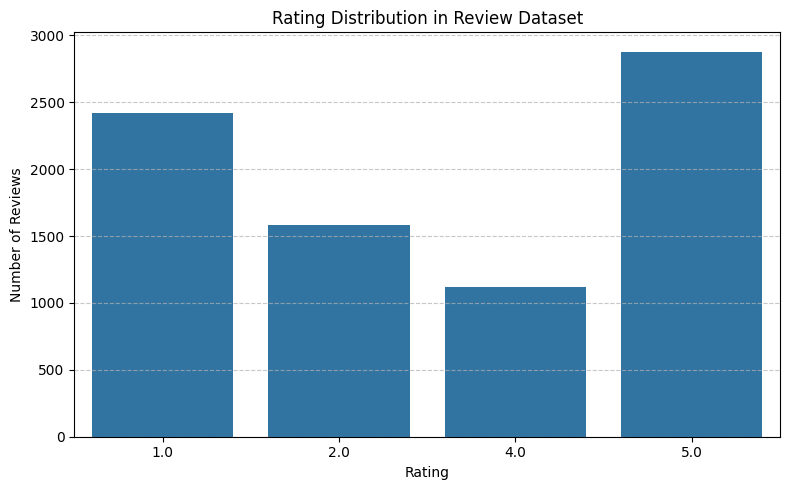

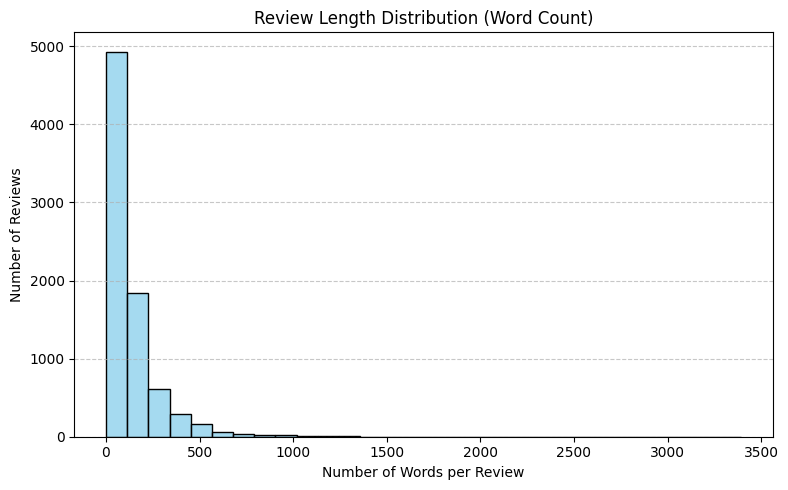

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic data inspection
print("📊 Basic Data Overview")
print(f"Total number of reviews: {len(reviews_df)}\n")

# Calculate word count if not yet added
reviews_df['word_count'] = reviews_df['review_text'].apply(lambda x: len(x.split()))

# View first few rows
print("🔍 Sample Rows:")
display(reviews_df.head())

# Check for missing values
print("\n❓ Missing Values:")
print(reviews_df.isnull().sum())

# Check label distribution
print("\nLabel Distribution:")
print(reviews_df['label'].value_counts())

# Plot count of each rating value
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=reviews_df)
plt.title("Rating Distribution in Review Dataset")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot histogram of review lengths
plt.figure(figsize=(8, 5))
sns.histplot(reviews_df['word_count'], bins=30, kde=False, color='skyblue')
plt.title("Review Length Distribution (Word Count)")
plt.xlabel("Number of Words per Review")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Plot to show how many negative and positive reviews in each category

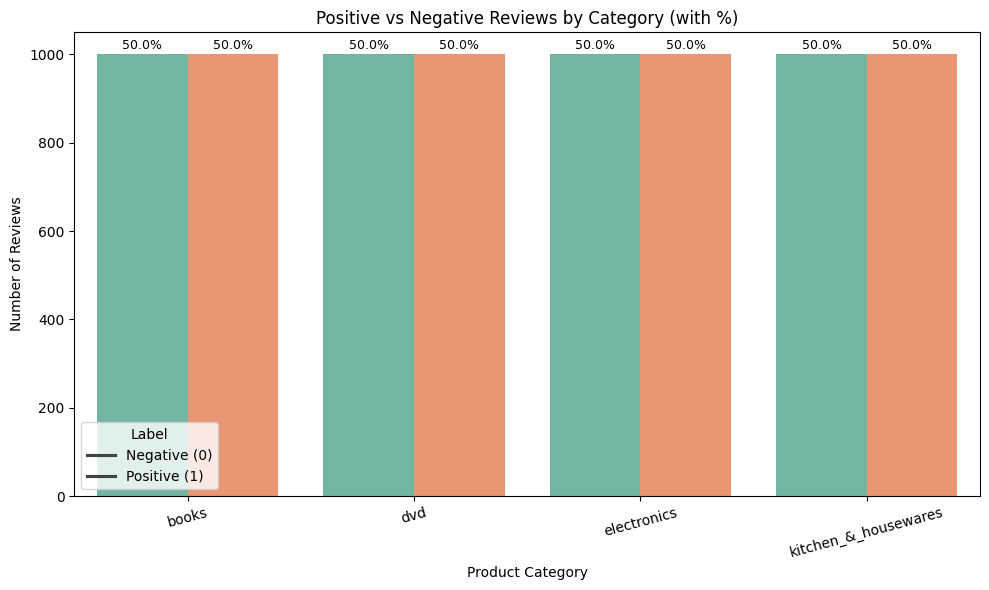

In [153]:
# Group and count reviews by category and label
category_counts = reviews_df.groupby(['category', 'label']).size().reset_index(name='count')

# Calculate percentage within each category
category_totals = reviews_df.groupby('category')['label'].value_counts(normalize=True).rename('percent').reset_index()

# Merge with counts
category_data = category_counts.merge(category_totals, on=['category', 'label'])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=category_data, x='category', y='count', hue='label', palette='Set2')

# Add percent labels on top of bars
for p, pct in zip(ax.patches, category_data['percent']):
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2, height + 5,
        f"{pct*100:.1f}%", ha="center", va="bottom", fontsize=9
    )

plt.title("Positive vs Negative Reviews by Category (with %)")
plt.xlabel("Product Category")
plt.ylabel("Number of Reviews")
plt.legend(title="Label", labels=["Negative (0)", "Positive (1)"])
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### Cleaning Review Text and Word Count Analysis

This step applies the `clean_text()` function to all review texts to produce a cleaned version for model training.

It then tokenizes the cleaned text and calculates the number of words per review.

- `cleaned_review_text`: the result of applying the text cleaning pipeline to `review_text`
- `cleaned_word_count`: the number of words in each cleaned review

First 10 rows of the updated dataset are displayed to verify the cleaning process.


In [154]:
# Apply clean text
# reviews_df['cleaned_review_text'] = reviews_df['review_text'].apply(clean_text)

reviews_df['cleaned_review_text'] = reviews_df['review_text'].apply(
    lambda x: clean_text(
        x,
        remove_stopwords=False,
        expand_contractions=False,
        split_compounds_words=True,
        stem=False,
        lemmatize=True,
        correct_spelling=True
    )
)


# Count the words of cleaned text
reviews_df['cleaned_word_count'] = reviews_df['cleaned_review_text'].apply(word_tokenize).apply(len)


# # Display the first few rows of the cleaned data
# data.head()
reviews_df.head(10)


,review_text,rating,label,category,word_count,cleaned_review_text,cleaned_word_count
0,Bought one recently from a Mervyns sale. Rice...,2.0,0,kitchen_&_housewares,133,bought one recently from a mervyn sale rice bu...,133
1,We have had braun coffee pots for several year...,4.0,1,kitchen_&_housewares,45,we have had braun coffee pot for several year ...,45
2,Ok. This is the 2nd ipod mini transmitter I ha...,1.0,0,electronics,38,ok this is the and ipod mini transmitter i hav...,38
3,I previously had purchased a different brand o...,5.0,1,electronics,110,i previously had purchased a different brand o...,110
4,Beware of the Everyman's Library edition of th...,1.0,0,books,76,beware of the everyman library edition of this...,76
5,Despite managing to give fleeting impressions ...,2.0,0,dvd,196,despite managing to give fleeting impression o...,196
6,This is very misleading. this item is only hal...,1.0,0,kitchen_&_housewares,36,this is very misleading this item is only half...,36
7,so I'm supposed to believe that the horrible d...,2.0,0,dvd,36,so im supposed to believe that the horrible di...,36
8,I bought this backpack for walking to work eac...,5.0,1,electronics,92,i bought this backpack for walking to work eac...,92
9,This movie is basically about 12 yr. old boys ...,2.0,0,dvd,76,this movie is basically about of yr old boy cr...,76


### Filter Reviews by Cleaned Word Count

This step checks for and filters out reviews that are too short (fewer than 3 words) or too long (more than 300 words) after cleaning.

- Prints the number of overly short or long reviews
- Retains only reviews with 3 to 300 cleaned words
- Resets the DataFrame index
- Outputs the total number of remaining reviews and their label distribution


In [155]:
too_long_count = (reviews_df['cleaned_word_count'] > 300).sum()
print("Number of cleaned reviews with more than 300 cleaned words:", too_long_count)

print("Number of very short cleaned reviews:", (reviews_df['cleaned_word_count'] < 3).sum())

# Filter Between 3 and 300 words
# reviews_df = reviews_df[(reviews_df['cleaned_word_count'] >= 3) & (reviews_df['cleaned_word_count'] <= 300)].reset_index(drop=True)
# reviews_df = reviews_df[(reviews_df['word_count'] >= 3) & (reviews_df['word_count'] <= 300)].reset_index(drop=True)

print("\nBasic Data Inspection:")
print(f"Total number of reviews: {len(reviews_df)}")
print(f"Distribution of labels:\n{reviews_df['label'].value_counts()}")

Number of cleaned reviews with more than 300 cleaned words: 739
Number of very short cleaned reviews: 1

Basic Data Inspection:
Total number of reviews: 8000
Distribution of labels:
label
0    4000
1    4000
Name: count, dtype: int64


### Splitting the Dataset: Train, Validation, and Test Sets

This step splits the cleaned review dataset into three subsets for model training and evaluation:

- **80% Training Set**: Used to train the model
- **10% Validation Set**: Used to tune hyperparameters and monitor overfitting
- **10% Test Set**: Used for final model evaluation

Stratified sampling ensures that the distribution of sentiment labels (positive/negative) remains consistent across all subsets.


In [156]:
from sklearn.model_selection import train_test_split

# Create a stratification key that combines category and label
reviews_df['stratify_group'] = reviews_df['category'].astype(str) + '_' + reviews_df['label'].astype(str)

X = reviews_df['cleaned_review_text']
y = reviews_df['label']
stratify_col = reviews_df['stratify_group']

# First split: 80% train, 20% temp (stratify by category + label)
X_train, X_temp, y_train, y_temp, strat_train, strat_temp = train_test_split(
    X, y, stratify_col, test_size=0.2, random_state=42)

# Second split: 10% val, 10% test (continue stratifying using strat_temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=strat_temp, random_state=42)

### Tokenization and Padding

This step converts the cleaned review text into numerical format suitable for neural networks:

- **Tokenizer**: Builds a vocabulary of the top `10,000` most frequent words, replacing out-of-vocabulary terms with `<OOV>`.
- **Texts to Sequences**: Each review is converted into a sequence of integers representing word indices.
- **Padding**: All sequences are padded (or truncated) to a uniform length of `150` tokens to ensure consistent input size for the model.


In [157]:
# Step 2: Tokenize and Pad Sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000       # Maximum number of unique words to keep
max_len = 250            # Max number of tokens per review
oov_token = "<OOV>"      # Token for out-of-vocabulary words

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [158]:
# Why save?
# To ensure that
# The same word-to-index mapping is used during inference
# You don’t need to re-fit on training data again

import pickle

# Save the fitted tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ Tokenizer saved as 'tokenizer.pkl'")


✅ Tokenizer saved as 'tokenizer.pkl'


### 🧠 Load GloVe Embeddings and Create Embedding Matrix

This step loads pre-trained GloVe word embeddings (`glove.6B.100d.txt`) and builds an embedding matrix to initialize the model's embedding layer.

- **GloVe Loading**: Reads the GloVe file and stores word vectors in a dictionary (`embedding_index`), where each key is a word and the value is a 100-dimensional vector.
- **Embedding Matrix**: For each word in the tokenizer's vocabulary:
  - If the word exists in the GloVe dictionary, its vector is added to the matrix.
  - Words not found in GloVe remain as zero vectors (to be learned during training if trainable).

This matrix will be used to initialize the weights of the embedding layer

In [159]:
# Step 3: Load GloVe Embeddings
import numpy as np

embedding_index = {}
with open("glove/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector


# Step 4: Create Embedding Matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

covered = sum(1 for word in tokenizer.word_index if word in embedding_index)
print(f"{covered}/{len(tokenizer.word_index)} words covered by GloVe")

24556/30023 words covered by GloVe


This step identifies words in the tokenizer's vocabulary that are **not found in the GloVe embedding index**. These words will be assigned zero vectors unless the embedding layer is set to `trainable=True`.

- Displays a sample of up to 200 missing words
- Prints the total number of uncovered words
- Useful for debugging vocabulary gaps and deciding whether to apply spell correction or use trainable embeddings

In [160]:
#  Log Uncovered Words
missing_words = [word for word in tokenizer.word_index if word not in embedding_index]
print(f"Missing example words: {missing_words[:200]}")
print(f"Total missing: {len(missing_words)}")

Missing example words: ['<OOV>', 'theyve', 'amazoncom', 'cooky', 'shouldnt', 'couldve', 'werent', 'hadnt', 'theyd', 'onoff', 'yearold', 'theyll', 'smoothy', 'reallife', 'wellwritten', 'exwife', 'thoughtprovoking', 'dvdr', 'qty', 'highquality', 'overthetop', 'allclad', 'itll', 'musthave', 'middleaged', 'foodsaver', 'titbit', 'mustsee', 'fastpaced', 'selfhelp', 'quadrofx', 'oldfashioned', 'motherinlaw', 'wellmade', 'keyboardmouse', 'shouldve', 'promedia', 'blackandwhite', 'allinone', 'africanamerican', 'hiassins', 'halfhour', 'onedimensional', 'wusthoff', 'gehrys', 'oneyear', 'nobrainer', 'welldesigned', 'hillermans', 'viewsonics', 'metrokane', 'firstrate', 'shortterm', 'bedmaker', 'zojirushi', 'sidebyside', 'noisecancelling', 'welldeveloped', 'schanzkowska', 'writerdirector', 'heavyduty', 'stepbystep', 'motherdaughter', 'firsttime', 'itbut', 'vacuvin', 'uptodate', 'warrantee', 'dlinks', 'bigscreen', 'selfcentered', 'welldone', 'selfindulgent', 'icarplay', 'clickwheel', 'dvdrs', 'hiaasen

### Data Generator for Batch Training

This function creates a Python generator that yields batches of input and label data for model training.

- **Inputs**:
  - `X`, `y`: Arrays or sequences of input features and labels
  - `batch_size`: Number of samples per batch
- **Output**: Batches of `(X_batch, y_batch)` as NumPy arrays
- **Why use it?**: Efficiently feeds data to the model in chunks, especially useful for large datasets that can't fit in memory all at once.

This generator is compatible with Keras `model.fit()` and helps in training with dynamic or memory-constrained data pipelines.


In [161]:
# Step 5: Create Data Generator
def data_generator(X, y, batch_size):
    length = len(X)
    while True:
        for i in range(0, length, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            yield np.array(X_batch), np.array(y_batch)

### Step 6: Build the LSTM Model with GloVe Embeddings

This step defines a sequential deep learning model for binary sentiment classification using an LSTM-based architecture with pre-trained GloVe embeddings.

**Model architecture:**
- `Embedding`: Initializes the embedding layer with GloVe vectors (`trainable=True`) to allow fine-tuning of word representations.
- `Bidirectional LSTM (64 units)`: Processes input sequences in both forward and backward directions while retaining sequence output.
- `Bidirectional LSTM (32 units)`: Learns deeper temporal patterns from the first LSTM output.
- `Dropout (0.5)`: Helps prevent overfitting by randomly deactivating 50% of neurons.
- `Dense (24 units, ReLU)`: Fully connected layer for feature transformation.
- `Dense (1 unit, Sigmoid)`: Final output layer for binary classification.

The model is compiled using:
- `binary_crossentropy` as the loss function (appropriate for binary labels)
- `adam` optimizer
- `accuracy` as the evaluation metric


In [165]:
# Step 6: Build Model with GloVe Embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(128,return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.7),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


### Step 7: Train the Model Using Data Generators

This step trains the LSTM model using Python generators and applies training optimization strategies with callbacks.

**Key components:**
- `data_generator`: Feeds batches of padded sequences and labels to the model to reduce memory usage.
- `EarlyStopping`: Stops training if the validation loss doesn't improve for 3 consecutive epochs, restoring the best weights.
- `ReduceLROnPlateau`: Reduces the learning rate by half if the validation loss plateaus for 2 epochs, helping to fine-tune convergence.

**Training settings:**
- `batch_size = 128`
- `epochs = 20`
- Training and validation steps are calculated based on batch size to fully cover each dataset.

The model is trained with `model.fit()` using the generators and monitored for validation performance with early stopping and learning rate scheduling.


In [166]:
# Step 7: TYrain the Model with Generators
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

batch_size = 128

train_gen = data_generator(X_train_pad, y_train.tolist(), batch_size)
val_gen = data_generator(X_val_pad, y_val.tolist(), batch_size)

steps_per_epoch = len(X_train_pad) // batch_size
val_steps = len(X_val_pad) // batch_size

history = model.fit(train_gen,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_gen,
          validation_steps=val_steps,
          epochs=20,
          callbacks=callbacks)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 771ms/step - accuracy: 0.5174 - loss: 0.6988 - val_accuracy: 0.6562 - val_loss: 0.6352 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 793ms/step - accuracy: 0.6464 - loss: 0.6332 - val_accuracy: 0.6732 - val_loss: 0.6075 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 931ms/step - accuracy: 0.7318 - loss: 0.5451 - val_accuracy: 0.7827 - val_loss: 0.4745 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 918ms/step - accuracy: 0.8143 - loss: 0.4330 - val_accuracy: 0.8006 - val_loss: 0.4757 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 927ms/step - accuracy: 0.8603 - loss: 0.3397 - val_accuracy: 0.7812 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 930ms/step - accuracy: 0.8999 - loss: 0.2632 - val_accuracy: 0.8274 - val_loss: 0.4123 - learning_rate: 5.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 947ms/step - accuracy: 0.9228 - loss

### Step 8: Evaluate the Model on the Test Set

This step evaluates the trained model using the **unseen test dataset** to measure its generalization performance.

**Key components:**
- `test_gen`: A generator that yields batches of test data.
- `model.evaluate()`: Computes the loss and accuracy on the test set using a specified number of steps.

The final test accuracy is printed to assess how well the model performs on completely unseen data.


In [170]:
# Step 8: Evaluate on Test Sets
test_gen = data_generator(X_test_pad, y_test.tolist(), batch_size)
test_steps = len(X_test_pad) // batch_size

loss, accuracy = model.evaluate(test_gen, steps=test_steps)
print(f"Test Accuracy: {accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.7946 - loss: 0.5208
Test Accuracy: 0.7982


### Visualize Training History: Accuracy and Loss

This step plots the model's training and validation performance over each epoch:

- `accuracy` and `val_accuracy`: Show how well the model is learning and generalizing.
- `loss` and `val_loss`: Help detect overfitting or underfitting.

Visualizing these metrics helps you:
- Monitor model convergence
- Identify if/when the model starts overfitting (e.g., validation loss increasing while training loss decreases)
- Decide whether early stopping worked effectively


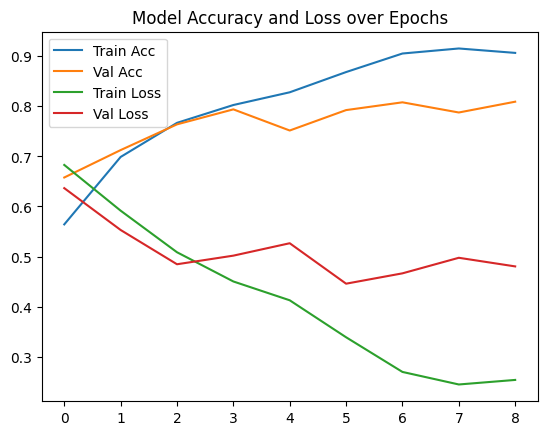

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Accuracy and Loss over Epochs")
plt.show()

### Save the Trained Model

This step saves the final trained model to disk as an `.h5` file using `model.save()`.


In [173]:
model.save("sentiment_model_best_81acc.h5")

### Load a Saved Model

This step loads a previously saved Keras model from an `.h5` file using `load_model()`.


In [174]:
from tensorflow.keras.models import load_model

lstm_model = load_model("sentiment_model_best_81acc.h5")  # or the filename you saved

### Sentiment Prediction for New Text

These functions allow you to preprocess a single review and predict its sentiment using a trained model:

- **`preprocess_review()`**:  
  Converts raw text into a token sequence using the saved tokenizer and pads it to match the model’s expected input length.

- **`predict_sentiment()`**:  
  Uses the model to predict sentiment for the given text. Outputs:
  - `"Positive"` if the model's sigmoid output ≥ 0.5
  - `"Negative"` otherwise
  - Also prints the model's confidence score

In [175]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_review(text, tokenizer, max_len=200):
    # Clean text manually if needed (optional)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')
    return padded

def predict_sentiment(text):
    # text = clean_text(text)
    
    padded = preprocess_review(text, tokenizer)
    prediction = lstm_model.predict(padded)[0][0]  # sigmoid output
    sentiment = "Positive" if prediction >= 0.5 else "Negative"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    print(f"\033[91mReview\033[0m: \"{text}\" \033[91mPrediction\033[0m: {sentiment} ({confidence:.2f} confidence)")

#     print("\033[91mThis is red text\033[0m")
# print("\033[92mThis is green text\033[0m")
# print("\033[93mThis is yellow text\033[0m")
# print("\033[94mThis is blue text\033[0m")


    # print(padded)
    return sentiment

In [176]:
sample_reviews = [
    # Positive
"The customer service was exceptional. They went above and beyond to help me.",
"I'm absolutely thrilled with my purchase. It exceeded all my expectations.",
"The atmosphere of the restaurant was so cozy and inviting. I felt right at home.",
"This is the best book I've read all year. The writing is captivating.",
"Highly recommend this product to anyone looking for a reliable and efficient solution.",
    #Negative
"What a waste of money! This is the worst product I've ever bought.",
"The entire experience was a disaster from start to finish. I will never return.",
"The quality of the materials was incredibly poor and flimsy.",
"I was utterly disappointed with the lack of support and the unhelpful staff.",
"This film was boring and predictable. I couldn't wait for it to end."
"I don't like this movie, too bad",
"It's not good at all",
"i do not like it, waste time"
"i don't like it",
"it's not good"
]

sample_reviews_df = pd.DataFrame(sample_reviews, columns=['review_text'])

sample_reviews_df['Prediction'] = sample_reviews_df['review_text'].apply(predict_sentiment)

# sample_reviews_df['Prediction'] = sample_reviews_df['review_text'].apply(
#     lambda x: clean_text(
#         x,
#         remove_stopwords=False,
#         expand_contractions=True,
#         split_compounds_words=True,
#         stem=False,
#         lemmatize=True,
#         correct_spelling=True
#     )
# ).apply(predict_sentiment)

sample_reviews_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Review: "The customer service was exceptional. They went above and beyond to help me." Prediction: Positive (0.70 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: "I'm absolutely thrilled with my purchase. It exceeded all my expectations." Prediction: Positive (0.97 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Review: "The atmosphere of the restaurant was so cozy and inviting. I felt right at home." Prediction: Positive (0.74 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: "This is the best book I've read all year. The writing is captivating." Prediction: Positive (0.94 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: "Highly recommend this product to anyone looking for a reliable and efficient solution." Prediction: Positive (0.98 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: "What a waste of money! This is the worst product I've ever bought." Prediction: Negative (0.98 confidence)
1/1 ━━━━━━━━━━━━━━━━

,review_text,Prediction
0,The customer service was exceptional. They wen...,Positive
1,I'm absolutely thrilled with my purchase. It e...,Positive
2,The atmosphere of the restaurant was so cozy a...,Positive
3,This is the best book I've read all year. The ...,Positive
4,Highly recommend this product to anyone lookin...,Positive


In [144]:
predict_sentiment("I absolutely loved this product. It exceeded all my expectations!")
predict_sentiment("This was terrible. Waste of time and money.")

predict_sentiment("I don't like this")

predict_sentiment("It isn't want I expected to be like this")

predict_sentiment('I will not creaet a review for this because it is not worth it, but it is good for nothing')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Review: "I absolutely loved this product. It exceeded all my expectations!" Prediction: Positive (0.94 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Review: "This was terrible. Waste of time and money." Prediction: Negative (0.93 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Review: "I don't like this" Prediction: Positive (0.71 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Review: "It isn't want I expected to be like this" Prediction: Negative (0.57 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Review: "I will not creaet a review for this because it is not worth it, but it is good for nothing" Prediction: Negative (0.88 confidence)


'Negative'

#### Check the unlabelled review files

In [29]:
# Get all unlabeled review

unlabeled_review_df = parse_all_unlabeled_files(base_folder='./sorted_data_acl', categories=['books', 'dvd', 'electronics', 'kitchen_&_housewares'])


In [30]:
unlabeled_review_df.head()

,review_text,rating,label,category
0,I watched the first season last year when my r...,5.0,1,dvd
1,"Pros: Compact, all in one Corded has reasonab...",4.0,1,electronics
2,Our toastmaster oven caught fire over the week...,1.0,0,kitchen_&_housewares
3,I LOVE these Kathy Smith DVDs. There is enoug...,5.0,1,dvd
4,"awesome apple keyboard, it came brand new and ...",5.0,1,electronics


In [31]:
predict_sentiment(unlabeled_review_df['review_text'][2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Negative (0.90 confidence)


'Negative'

In [40]:
unlabeled_review_df.loc[:500, 'Prediction'] = unlabeled_review_df.loc[:500, 'review_text'].apply(clean_text).apply(predict_sentiment)
# unlabeled_review_df.loc[:500, 'word_length'] = unlabeled_review_df.loc[:500, 'review_text'].apply(word_tokenize).apply(len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: Positive (0.94 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: Positive (0.93 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: Negative (0.79 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: Positive (0.96 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: Positive (0.95 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: Positive (0.63 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Negative (0.93 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction: Positive (0.96 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Negative (0.75 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Positive (0.94 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Positive (0.92 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Negative (0.93 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: Positive (0.95 confidence)

In [41]:
unlabeled_review_df.head(20)

,review_text,rating,label,category,Prediction
0,I watched the first season last year when my r...,5.0,1,dvd,Positive
1,"Pros: Compact, all in one Corded has reasonab...",4.0,1,electronics,Positive
2,Our toastmaster oven caught fire over the week...,1.0,0,kitchen_&_housewares,Negative
3,I LOVE these Kathy Smith DVDs. There is enoug...,5.0,1,dvd,Positive
4,"awesome apple keyboard, it came brand new and ...",5.0,1,electronics,Positive
5,This movie well it was boosted up like it was ...,2.0,0,dvd,Positive
6,i agree these sheets are horrible.. i should h...,1.0,0,kitchen_&_housewares,Negative
7,"This is an extraordinary, cute and very well p...",5.0,1,electronics,Positive
8,I first saw this film as a young teenager when...,5.0,1,dvd,Negative
9,"I have the new Canon S3 IS camera, and this wo...",5.0,1,electronics,Positive


In [38]:
unlabeled_review_df.iloc[5]

review_text    This movie well it was boosted up like it was ...
rating                                                       2.0
label                                                          0
category                                                     dvd
Prediction                                              Positive
Name: 5, dtype: object

In [ ]:
unlabeled_sample = unlabeled_review_df['review_text'][5]
print(unlabeled_sample)

This movie well it was boosted up like it was something really great. It had its moments but man. It had its weak times too. The little monster in this movie was just screaming like a girl the whole movie and that was really annoying. You can check it out. I didn't like it too much though. Oh well thats my opinion. Maybe you can find some good in it.
